# Cloud Inpainting on SEN3 Data
This notebook is a quick test to load, mask with clouds and then try and recover the data hidden by clouds using an inpainting DL model

In [1]:
import utils.prepare_dataset as predat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from network.model import coarseNet
from network.loss import lossL1
from network.gated_conv import GatedConv2D, GatedDeConv2D
import keras


2024-06-24 08:54:24.417241: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 08:54:24.417749: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 08:54:24.421343: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 08:54:24.466973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 08:54:25.298568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Extracting the bands from the Xarrays

The goal here is to convert the data into a more tensorflow friendly data format

In [2]:
dsnp_c = np.moveaxis(np.load("Cloudy_DS2.npy"),3,0)
dsnp = np.moveaxis(np.load("Ground_truth2.npy"),3,0)

In [3]:
#Data normalisation

"""for i in range(dsnp.shape[3]):
    for j in range(11):
        dsnp[:,:,i,j] = (dsnp[:,:,i,j] - np.min(dsnp[:,:,i,j]))/(np.max(dsnp[:,:,i,j]) - np.min(dsnp[:,:,i,j]))
        dsnp_c[:,:,i,j] = (dsnp_c[:,:,i,j] - np.min(dsnp_c[:,:,i,j]))/(np.max(dsnp_c[:,:,i,j]) - np.min(dsnp_c[:,:,i,j]))"""

'for i in range(dsnp.shape[3]):\n    for j in range(11):\n        dsnp[:,:,i,j] = (dsnp[:,:,i,j] - np.min(dsnp[:,:,i,j]))/(np.max(dsnp[:,:,i,j]) - np.min(dsnp[:,:,i,j]))\n        dsnp_c[:,:,i,j] = (dsnp_c[:,:,i,j] - np.min(dsnp_c[:,:,i,j]))/(np.max(dsnp_c[:,:,i,j]) - np.min(dsnp_c[:,:,i,j]))'

In [4]:
#Split into training and test set


train_ds = tf.data.Dataset.from_tensor_slices((np.stack((dsnp_c[:800,:,:,3],dsnp_c[:800,:,:,-1]), axis=-1), dsnp[:800,:,:,3]))
test_ds = tf.data.Dataset.from_tensor_slices((np.stack((dsnp_c[800:,:,:,3], dsnp_c[800:,:,:,-1]),axis=-1), dsnp[800:,:,:,3]))

In [5]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 800

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.batch(BATCH_SIZE)

In [2]:
model = coarseNet()
opti = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opti, loss="mse")
print(model.model.summary())


/home/etienne/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'gated_conv2d_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gated_conv2d (GatedConv2D)      │ (None, 256, 256, 64)   │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_1 (GatedConv2D)    │ (None, 128, 128, 128)  │       262,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_2 (GatedConv2D)    │ (None, 128, 128, 128)  │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_3 (GatedConv2D)    │ (None, 64, 64, 256)    │     1,050,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_4 (GatedConv2D)    │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_5 (GatedConv2D)    │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_6 (GatedConv2D)    │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_7 (GatedConv2D)    │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_8 (GatedConv2D)    │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_9 (GatedConv2D)    │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_10 (GatedConv2D)   │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_11 (GatedConv2D)   │ (None, 64, 64, 256)    │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_de_conv2d (GatedDeConv2D) │ (None, 128, 128, 128)  │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_12 (GatedConv2D)   │ (None, 128, 128, 128)  │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_de_conv2d_1               │ (None, 256, 256, 64)   │       147,840 │
│ (GatedDeConv2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_13 (GatedConv2D)   │ (None, 256, 256, 32)   │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_conv2d_14 (GatedConv2D)   │ (None, 256, 256, 1)    │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,136,710 (46.30 MB)

 Trainable params: 12,130,756 (46.28 MB)

 Non-trainable params: 5,954 (23.26 KB)

None


In [7]:
#np.max(dsnp_c[:,:,:,0])
out = model.predict(dsnp_c[1:2,:,:,1:3])[0,:,:,:]



#np.max(out)
#normalise prediction
#for i in range(11):
out2 = (np.log(out[:,:,:]) - np.min(np.log(out[:,:,:])))/(np.max(np.log(out[:,:,:])) - np.min(np.log(out[:,:,:])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/tmp/ipykernel_2486166/1346116816.py:9: RuntimeWarning: invalid value encountered in log
  out2 = (np.log(out[:,:,:]) - np.min(np.log(out[:,:,:])))/(np.max(np.log(out[:,:,:])) - np.min(np.log(out[:,:,:])))


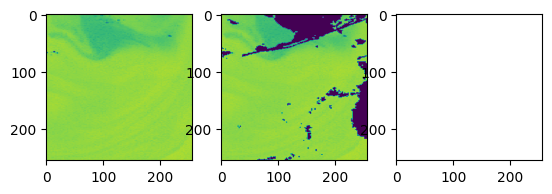

In [8]:
plt.subplot(1,3,1)
plt.imshow(dsnp[10,:,:,1])
plt.subplot(1,3,2)
plt.imshow(dsnp_c[10,:,:,1])
plt.subplot(1,3,3)
plt.imshow(out2[:,:,0])


In [10]:
model.fit(train_ds, epochs=1, validation_data=test_ds, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), keras.callbacks.ModelCheckpoint(filepath='coarseNet.keras', save_best_only=True, save_freq="epoch"), keras.callbacks.TensorBoard(log_dir='./logs'), keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0), keras.callbacks.CSVLogger('coarseNet.csv'), keras.callbacks.TerminateOnNaN()])


2024-06-24 08:47:00.191695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/coarse_net_1/sequential_1/gated_de_conv2d_1/leaky_re_lu_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/coarse_net_1/sequential_1/gated_de_conv2d_1/conv2d_24_1/add'.


 5/13 ━━━━━━━━━━━━━━━━━━━━ 10:02 75s/step - loss: 1.2050 - mae: 0.6016

In [ ]:
validation_loss = model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.0000e+00 - mae: 0.0000e+00


In [ ]:
#Load keras file 

#coarseNet.load_weights('coarseNet.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


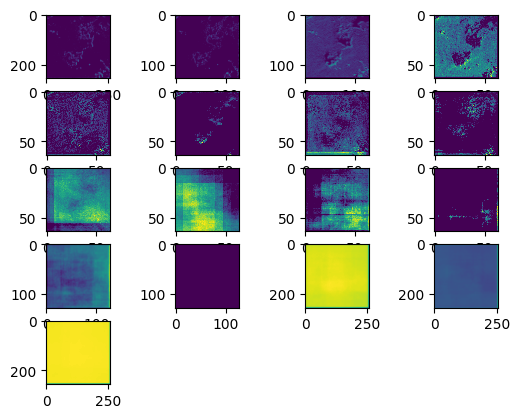

In [ ]:
extractor = keras.Model(inputs=model.model.inputs, outputs=[layer.output for layer in model.model.layers])
features = extractor.predict(dsnp_c[1:2,:,:,1:3])  


fig = plt.figure()
for i, feature in enumerate(features):
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(feature[0,:,:,0])
fig.savefig('features.png')